## Extensión

In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$

In [2]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulación

El modelo maximiza el rendimiento esperado total para un nivel fijo de varianza (riesgo) preespecificado. Matemáticamente, esto resulta en un problema de optimización convexa con restricciones cuadráticas.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Ahora, la variable de posición no tiene cotas; modelando el apalancamiento y venta en corto.

###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i =1$$

El riesgo estimado debe ser igual al nivel de varianza admisible preespecificado $\bar\sigma^2$:

$$x^\top \Sigma x = \bar\sigma^2$$

###  Función Objetivo
El objetivo es maximizar el rendimiento esperado del portafolio:

$$\max_x \mu^\top x $$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [78]:
V = 40 # varianza máxima admisible (sigma^2)
n_indices = 6

# Crear un modelo de optimización vacío
m = gp.Model()

M = 1000 
N = range(len(mu))

epsilon = 1e-8

# Agregar variables: x[i] denota la proporción invertida en la acción i
x = m.addMVar(len(N), lb=-np.inf, ub=np.inf, name="x")

# Restricción presupuestaria: todas las inversiones suman 1
m.addConstr(x.sum() == 1, name="Restriccion_Presupuesto")

# Restricción para fijar valor de z.
z = m.addMVar(len(N), vtype=gp.GRB.BINARY, name="activo_binario")
abs_x = m.addMVar(len(N), vtype=gp.GRB.CONTINUOUS, name="abs_x")

m.addConstrs((abs_x[i] == gp.abs_(x[i]) for i in N), name='abs_x')
m.addConstrs((abs_x[j] <= z[j]*M for j in N ), name="activo_binario_upper")
m.addConstrs((z[j]*epsilon <= abs_x[j]for j in N ), name="activo_binario_lower")

# Restricción de número de indices.
m.addConstr(z.sum() <= n_indices, name="Restriccion_Presupuesto")

# Límite en la varianza
restriccion_riesgo = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="restriccion_riesgo")

m.params.MIPGap = 0.01
m.params.FeasibilityTol = 1e-9
m.params.OptimalityTol = 1e-9
m.params.NonConvex = 2

# Definir la función objetivo: Maximizar el rendimiento esperado
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)


m.params.TimeLimit = 300  # Establece un límite de tiempo de 300 segundos (5 minutos)


Set parameter MIPGap to value 0.01
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 300


Resolvemos:

In [79]:
m.optimize() 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22 rows, 30 columns and 60 nonzeros
Model fingerprint: 0xed0dfdfe
Model has 1 quadratic constraint
Model has 10 general constraints
Variable types: 20 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-08, 1e+03]
  QMatrix range    [1e+01, 4e+02]
  Objective range  [4e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
  QRHS range       [4e+01, 4e+01]
Presolve added 30 rows and 30 columns
Presolve time: 0.02s
Presolved: 52 rows, 60 columns, 140 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 40 continuous, 20 integer (20 binary)

Root relaxation: objective 6.085024e+03, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

Mostrar los datos básicos de la solución:

In [80]:
print(f"Varianza:         {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución:    {m.Runtime:.2f} segundos\n")

# Imprimir inversiones (con valores no despreciables, es decir, > 1e-5)
positions = pd.Series(name="Posición", data=x.X, index=mu.index)
print(f"Número de transacciones positivas: {positions[positions > 1e-8].count()}\n")
print(positions[positions > 0])
print(f"\nNúmero de transacciones negativas: {positions[positions < -1e-8].count()}\n")
print(positions[positions < 0])

Varianza:         39.999984
Tiempo de solución:    0.17 segundos

Número de transacciones positivas: 5

BCI Cierre Ix      0.426896
CCU Cierre Ix      0.126385
CMPC Cierre Ix     0.225272
IANSA Cierre Ix    0.112388
ZOFRI Cierre Ix    0.507912
Name: Posición, dtype: float64

Número de transacciones negativas: 1

SOCOVESA Cierre Ix   -0.398854
Name: Posición, dtype: float64


In [81]:
df = pd.DataFrame(
    index=mu.index,
    data={
        "x": x.X,
    },
).round(6)

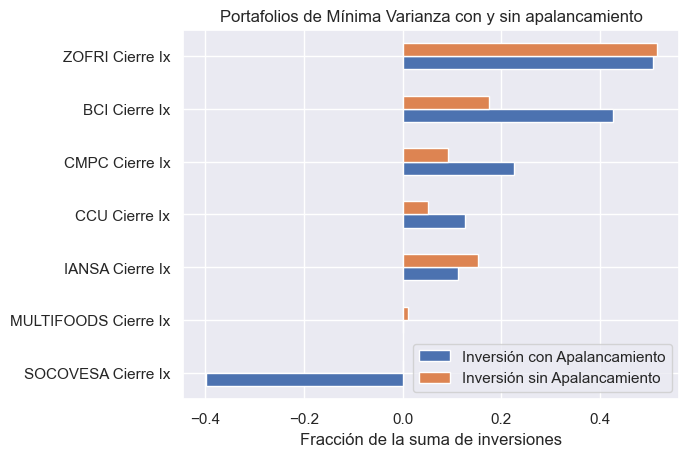

In [82]:
# adjust RHS of short constraint
x.lb = 0
x.ub = 1
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
mask = (abs(df["x"]) > 1e-8) | (x.X > 1e-8)
df2 = pd.DataFrame(
    index=df["x"][mask].index,
    data={
        "Inversión con Apalancamiento": df["x"],
        "Inversión sin Apalancamiento": x.X[mask],
    },
).sort_values(by=["Inversión con Apalancamiento"], ascending=True)

axs = df2.plot.barh()
axs.set_xlabel("Fracción de la suma de inversiones")
plt.title("Portafolios de Mínima Varianza con y sin apalancamiento")
plt.show()